In [107]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [1]:
import requests
import zipfile
import os

# Correct URL to download the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"
response = requests.get(url)

# Save the zip file
with open("bank.zip", "wb") as file:
    file.write(response.content)

# Unzip the file
with zipfile.ZipFile("bank.zip", "r") as zip_ref:
    zip_ref.extractall("bank-marketing")

# List the extracted files
extracted_files = os.listdir("bank-marketing")
print(f"Extracted files: {extracted_files}")


Extracted files: ['bank-full.csv', 'bank-names.txt', 'bank.csv']


In [60]:
df = pd.read_csv('bank-marketing/bank-full.csv', sep=';') 

In [61]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [62]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


In [89]:
df = df[['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome','y']]
df.shape

(45211, 15)

In [64]:
df.y = df.y.map(lambda x: 1 if x == 'yes' else 0)

In [90]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[df.dtypes != 'object'].index)

numerical.remove('y')
len(numerical+categorical)

14

In [69]:
df[categorical].nunique()

job          12
marital       3
education     4
housing       2
contact       3
month        12
poutcome      4
dtype: int64

In [70]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

### Question 1: ROC AUC feature importance

In [73]:
for col in numerical:
    print("column:", col)
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[[col]].to_dict('records')
    X_train = dv.fit_transform(train_dict)


    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_train)[:, 1]
    y_decision = (y_pred >= 0.5)


    print('ROC AUC is:', roc_auc_score(y_train, y_pred))
    print()

column: age
ROC AUC is: 0.48781428247265596

column: balance
ROC AUC is: 0.5888313805382317

column: day
ROC AUC is: 0.525957882383908

column: duration
ROC AUC is: 0.8147002759670778

column: campaign
ROC AUC is: 0.5714543015682159

column: pdays
ROC AUC is: 0.5901276247352144

column: previous
ROC AUC is: 0.5985653242764153



### Question 2: Training the model

In [91]:
# dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict('records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [92]:
X_val = dv.transform(df_val.to_dict('records'))

y_pred = model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
print('AUC is:', auc(fpr, tpr).round(3))

AUC is: 0.901


In [84]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [95]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)
roc_auc_score(y_val, y_pred).round(3)

0.901

### Question 3: Precision and Recall

In [98]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, precision, recall))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

C:\Users\rkizm\AppData\Local\Temp\ipykernel_8476\3720081089.py:18: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


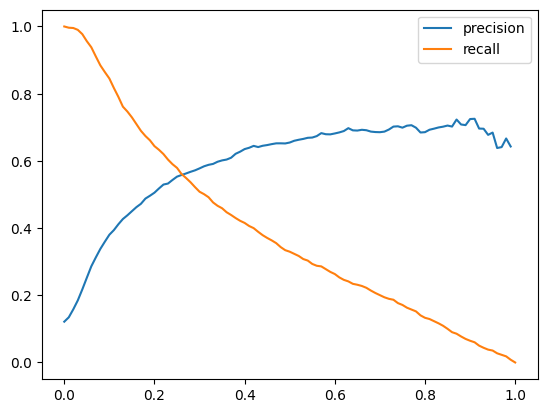

In [101]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

### Question 4: F1 score

In [102]:
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

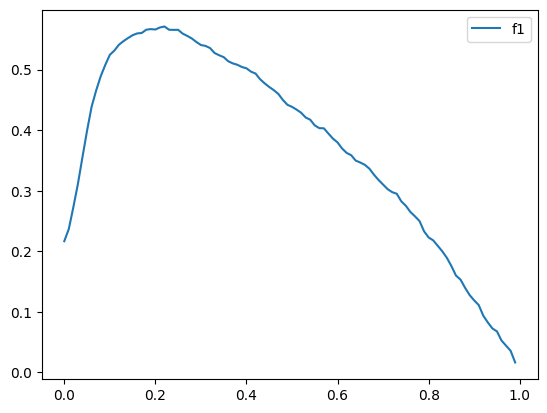

In [103]:
plt.plot(df_scores.threshold, df_scores['f1'], label='f1')
plt.legend()

### Question 5: 5-Fold CV

In [105]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


### Question 6. Best C 

In [106]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006
